In [2]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Ticker symbol for S&P 500 index
ticker_symbol = '^GSPC'

# Fetch historical data
sp500_data = yf.download(ticker_symbol, start='1900-01-01', end='2023-12-31')

# Display the fetched data
print(sp500_data)

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1927-12-30    17.660000    17.660000    17.660000    17.660000    17.660000   
1928-01-03    17.760000    17.760000    17.760000    17.760000    17.760000   
1928-01-04    17.719999    17.719999    17.719999    17.719999    17.719999   
1928-01-05    17.549999    17.549999    17.549999    17.549999    17.549999   
1928-01-06    17.660000    17.660000    17.660000    17.660000    17.660000   
...                 ...          ...          ...          ...          ...   
2023-12-12  4618.299805  4643.930176  4608.089844  4643.700195  4643.700195   
2023-12-13  4646.200195  4709.689941  4643.229980  4707.089844  4707.089844   
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941

In [4]:
#LOG RELATIVE - currently not used
log_today = np.log(sp500_data['Close'])
log_yesterday =np.log(sp500_data['Close'].shift(1))
sqrt_252 = np.sqrt(252)
log_data = (log_today/log_yesterday)*sqrt_252
log_data

Date
1927-12-30          NaN
1928-01-03    15.905726
1928-01-04    15.862066
1928-01-05    15.821274
1928-01-06    15.909128
                ...    
2023-12-12    15.883140
2023-12-13    15.899999
2023-12-14    15.879470
2023-12-15    15.874365
2023-12-18    15.884597
Name: Close, Length: 24107, dtype: float64

Text(0.5, 1.0, 'Log Relative for SP500')

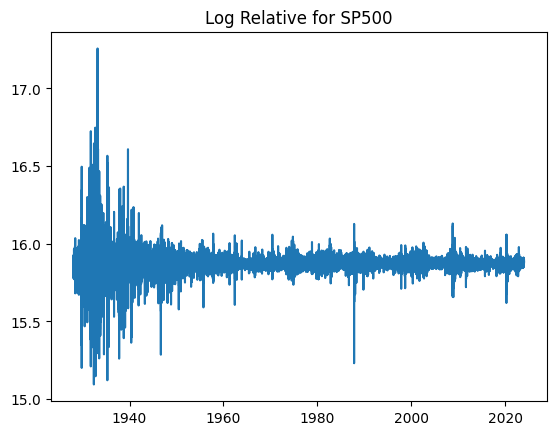

In [5]:
plt.plot(log_data)
plt.title('Log Relative for SP500')

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close  \
Date                                                             
1983-01-03   140.649994   141.330002   138.199997   138.339996   
1983-01-04   138.330002   141.360001   138.080002   141.360001   
1983-01-05   141.350006   142.600006   141.149994   141.960007   
1983-01-06   142.009995   145.770004   142.009995   145.270004   
1983-01-07   145.270004   146.460007   145.149994   145.179993   
...                 ...          ...          ...          ...   
2023-12-12  4618.299805  4643.930176  4608.089844  4643.700195   
2023-12-13  4646.200195  4709.689941  4643.229980  4707.089844   
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941   
2023-12-18  4725.580078  4746.629883  4725.580078  4744.509766   

            Garman_Klass_Estimator  
Date                               

Text(0.5, 1.0, 'Garman_Klass_Estimator')

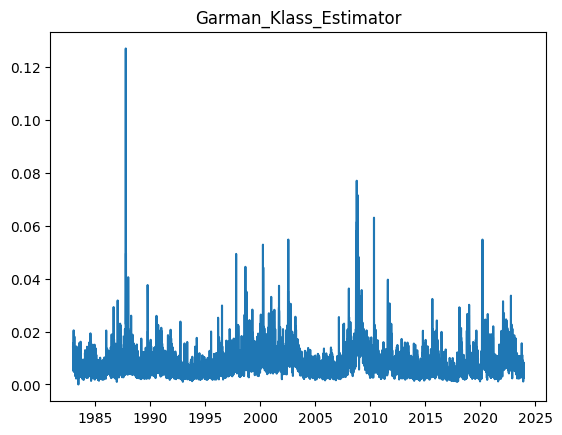

In [6]:
#CALCULATE GARMAN KLASS FOR EACH DAY

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='1983-01-01', end='2023-12-31')

# Calculate Garman-Klass estimator for each day
def calculate_gk_estimator(high, low, open_price, close):
    log_hl = np.log(high / low)
    log_co = np.log(close / open_price)
    log_co_square = log_co ** 2
    return np.sqrt((1 / (2)) * np.sum(log_hl ** 2 - (2 * np.log(2) - 1) * log_co_square))

# Create an empty list to store daily estimators
gk_estimators = []

# Iterate through the dataset day by day
for i in range(len(sp500)):
    high = sp500['High'].iloc[i]
    low = sp500['Low'].iloc[i]
    open_price = sp500['Open'].iloc[i]
    close = sp500['Close'].iloc[i]

    # Calculate the Garman-Klass estimator for the current day
    gk_est = calculate_gk_estimator(high, low, open_price, close)
    gk_estimators.append(gk_est)

# Add the daily estimators to the DataFrame
sp500['Garman_Klass_Estimator'] = gk_estimators

# Displaying the DataFrame with the Garman-Klass estimator for each day
print(sp500[['Open', 'High', 'Low', 'Close', 'Garman_Klass_Estimator']])
plt.plot(sp500['Garman_Klass_Estimator'])
plt.title('Garman_Klass_Estimator')

In [17]:
#HAR MODEL
import statsmodels.api as sm

# Assuming you have a pandas DataFrame 'data' with a column 'volatility' representing daily volatility
# Replace this with your actual dataset and column names

# Calculating different volatility measures
sp500['yesterday_volatility'] = sp500['Garman_Klass_Estimator'].shift(1)
sp500['avg_2_5_day_volatility'] = sp500['Garman_Klass_Estimator'].shift(6).rolling(window=5).mean()
sp500['avg_6_21_day_volatility'] = sp500['Garman_Klass_Estimator'].shift(21).rolling(window=16).mean()

# Dropping NaN values resulting from rolling means
data = sp500.dropna()

# Creating the HAR model
X = data[['yesterday_volatility', 'avg_2_5_day_volatility', 'avg_6_21_day_volatility']]
X = sm.add_constant(X)  # Adding a constant coefficient
y = data['Garman_Klass_Estimator']

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing the model summary
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     Garman_Klass_Estimator   R-squared:                       0.491
Model:                                OLS   Adj. R-squared:                  0.491
Method:                     Least Squares   F-statistic:                     3310.
Date:                    Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                            13:31:57   Log-Likelihood:                 41921.
No. Observations:                   10290   AIC:                        -8.383e+04
Df Residuals:                       10286   BIC:                        -8.380e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------